In [1]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame, create_animation, downsample, draw_circle
from pydpmd.utils import split_systems, join_systems
import matplotlib.pyplot as plt
import numpy as np
import os
from mode_resources import *
from system_building_resources import *
import subprocess
import h5py
from collections import defaultdict
from correlation_functions import compute_stress_acf

def read_data_from_ragged(f, key):
    data_dict = f[f'ragged/{key}']
    sorted_pd_keys = sorted(list(data_dict.keys()), key=lambda s: int(s.rsplit('_', 1)[1]))
    return [data_dict[k][()] for k in sorted_pd_keys]

def get_idx_in_B(A, B):
    mapping = { (x, y): i for i, (x, y) in enumerate(B) }
    return np.fromiter((mapping[tuple(row)] for row in A), dtype=int, count=A.shape[0])

def read_ragged(path):
    with h5py.File(path, 'r') as f:
        pair_dist = read_data_from_ragged(f, 'pair_dist')
        pair_forces = read_data_from_ragged(f, 'pair_forces')
        pair_ids = read_data_from_ragged(f, 'pair_ids')
    unique_pair_ids = np.unique(np.concatenate(pair_ids), axis=0)

    pair_dist_full = np.zeros((len(pair_dist), len(unique_pair_ids)))
    pair_forces_full = np.zeros((len(pair_dist), len(unique_pair_ids), 2))
    pair_ids_full = np.array([unique_pair_ids for i in range(len(pair_dist))])

    for i in tqdm(range(len(pair_dist))):
        mapped_ids = get_idx_in_B(pair_ids[i], pair_ids_full[i])
        pair_forces_full[i, mapped_ids] = pair_forces[i]
        pair_dist_full[i, mapped_ids] = pair_dist[i]
    return pair_dist_full, pair_forces_full, pair_ids_full

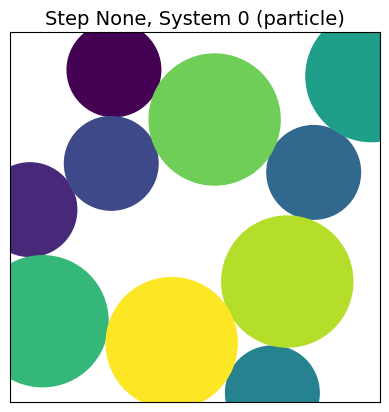

In [2]:
root = '/home/mmccraw/dev/data/11-01-25/'
data = dp.data.load(os.path.join(root, 'jamming/disk/jamming/'), location=["final", "init"])
draw_particles_frame(None, plt.gca(), data, 0, True, 'particle', 'viridis', 'final')

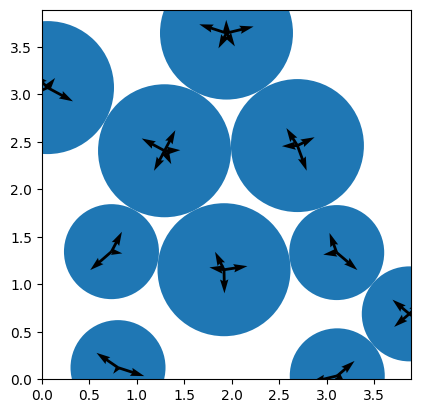

In [3]:
sid = 10

pid_0 = data.system_offset[sid]
pid_N = data.system_offset[sid + 1]
s_mask = np.all((data.final.pair_ids >= pid_0) & (data.final.pair_ids < pid_N), axis=1)
pair_forces = data.final.pair_forces.copy()[s_mask]
pair_ids = data.final.pair_ids.copy()[s_mask]
rattler_ids, non_rattler_ids = get_disk_rattlers(pair_forces, pair_ids, 3, True)

plt.gca().set_aspect('equal')
plt.xlim(0, data.box_size[sid, 0])
plt.ylim(0, data.box_size[sid, 1])
for i in range(pid_0, pid_N):
    p = np.mod(data.final.pos[i], data.box_size[sid])
    if i in non_rattler_ids:
        draw_circle(plt.gca(), p, data.rad[i])
        f = pair_forces[pair_ids[:, 0] == i].copy()
        f = -f[np.linalg.norm(f, axis=1) > 0]
        p_rep = np.repeat([p], f.shape[0], axis=0)
        plt.quiver(p_rep[:, 0], p_rep[:, 1], f[:, 0], f[:, 1], zorder=10)
    elif i in rattler_ids:
        draw_circle(plt.gca(), p, data.rad[i] / 2, color='r')

In [4]:
H_list, M_list, val_list, vec_list, non_rattler_ids_list = get_dynamical_matrix_modes_for_disk(data)

data_new = []
for sid, sys in enumerate(split_systems(data)):
    H = H_list[sid]
    M = M_list[sid]
    val = val_list[sid]
    vec = vec_list[sid]
    non_rattler_ids = non_rattler_ids_list[sid]
    N = non_rattler_ids.size

    pos = sys.final.pos[non_rattler_ids].copy()
    rad = sys.rad[non_rattler_ids].copy()
    mass = sys.mass[non_rattler_ids].copy()
    vec_all = np.sum(vec[:, 2:], axis=1)
    vec_all = np.column_stack((vec_all[:N], vec_all[N:]))
    
    # for delta_phi in [1e-2, 1e-3, 1e-4, 1e-5, -1e-5, -1e-4, -1e-3, -1e-2]:
    # for delta_phi in [1e-4]:
        # temperature = 1e-10
    for delta_phi in [-1e-6, -1e-4, -1e-2]:
    # for delta_phi in [-1e-6, -1e-4]:
        for temperature in [1e-12, 1e-11, 1e-10, 1e-9, 1e-8]:
            vel = vec_all.copy()
            scale = np.sqrt(temperature / (np.sum(mass * np.sum(vel ** 2, axis=1)) / (N - 1)))
            vel *= scale

            sys_new = build_disk_system_from_radii(rad, 'small', 0.1)
            sys_new.box_size = sys.box_size
            sys_new.pos = pos
            sys_new.rad = rad
            sys_new.mass = mass
            sys_new.vel = vel
            sys_new.e_interaction = sys.e_interaction

            sys_new.calculate_packing_fraction()
            sys_new.scale_to_packing_fraction(sys_new.packing_fraction + delta_phi)
            sys_new.add_array(np.array([sid]), 'original_system_id')
            sys_new.add_array(np.array([delta_phi]), 'delta_phi')
            sys_new.add_array(np.array([temperature]), 'target_temp')
            data_new.append(sys_new)

data_new = join_systems(data_new)

100%|██████████| 100/100 [00:00<00:00, 264.66it/s]


In [5]:
dynamics_path = os.path.join(root, 'dynamics')

In [123]:
dynamics_path = os.path.join(root, 'dynamics')
data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(dynamics_path)

n_steps = 1e6
save_freq = 1e2
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_disk_pbc_final"),
    dynamics_path,
    dynamics_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

Running for 1000000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Step 100000
Step 110000
Step 120000
Step 130000
Step 140000
DELETING /pair_dist
DELETING /pair_forces
DELETING /pair_ids
Step 150000
Step 160000
Step 170000
Step 180000
Step 190000
Step 200000
Step 210000
Step 220000
Step 230000
Step 240000
Step 250000
Step 260000
Step 270000
Step 280000
Step 290000
Step 300000
Step 310000
Step 320000
Step 330000
Step 340000
Step 350000
Step 360000
Step 370000
Step 380000
Step 390000
Step 400000
Step 410000
Step 420000
Step 430000
Step 440000
Step 450000
Step 460000
Step 470000
Step 480000
Step 490000
Step 500000
Step 510000
Step 520000
Step 530000
Step 540000
Step 550000
Step 560000
Step 570000
Step 580000
Step 590000
Step 600000
Step 610000
Step 620000
Step 630000
Step 640000
Step 650000
Step 660000
Step 670000
Step 680000
Step 690000
Step 700000
Step 710000
Step 720000
Step 730000
Step 740000
Step 750000
Step 760000
Ste

CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_disk_pbc_final', '/home/mmccraw/dev/data/11-01-25/dynamics', '/home/mmccraw/dev/data/11-01-25/dynamics', '1000000.0', '100.0', '0.01'], returncode=0)

In [118]:
with h5py.File(os.path.join(dynamics_path, 'trajectory.h5'), 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['pair_dist', 'pair_forces', 'pair_ids', 'pos', 'pressure', 'stress_tensor_total_x', 'stress_tensor_total_y', 'temperature', 'timestep', 'vel']>


In [124]:
final = dp.data.load(dynamics_path, location=['final', 'init'], load_trajectory=True)
final_partial = dp.data.load(dynamics_path, location=['final', 'init'], load_trajectory=True, load_full=False)
if 'pair_ids' in final.trajectory.fields():
    pair_dist = final.trajectory.pair_dist
    pair_forces = final.trajectory.pair_forces
    pair_ids = final.trajectory.pair_ids
else:
    pair_dist, pair_forces, pair_ids = read_ragged(os.path.join(dynamics_path, 'trajectory.h5'))
force = np.linalg.norm(pair_forces, axis=-1)
dist = pair_dist.copy()
radsum = np.sum(final.rad[pair_ids], axis=-1)
overlap = radsum - dist
pair_ids = pair_ids
mean_force = np.mean(force, axis=0)
mean_overlap = np.mean(overlap, axis=0)
temp = np.mean(final.trajectory.temperature, axis=0)
pressure = np.mean(final.trajectory.pressure, axis=0)
original_system_id = final.original_system_id.copy()
delta_phi = final.delta_phi.copy()
target_temp = final.target_temp.copy()
stress_acf, t = compute_stress_acf(final_partial, subtract_mean_stress=True)


stress = np.array(
    [
        np.column_stack(
            [final.trajectory[i].stress_tensor_total_x, final.trajectory[i].stress_tensor_total_y]
            ) for i in range(final.trajectory.num_frames())
    ]
)

Binned accumulation: 100%|██████████| 310005/310005 [00:04<00:00, 62615.00it/s] 


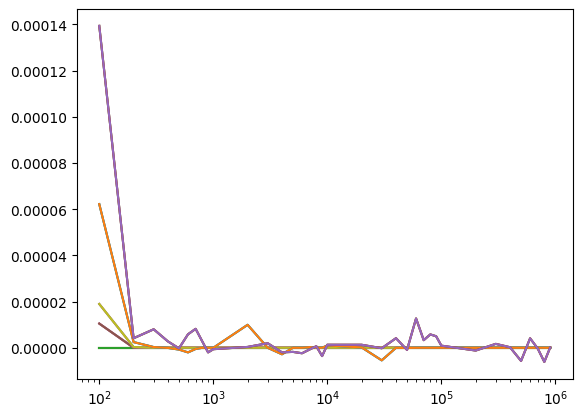

In [127]:
mask = original_system_id == 10
for temp in np.unique(target_temp[mask]):
    mask2 = (target_temp == temp) & mask
    for dphi in np.unique(delta_phi[mask2]):
        mask3 = (delta_phi == dphi) & mask2
        S = stress_acf[..., mask3].squeeze()
        plt.plot(t, S[:, 1])
# plt.yscale('log')
plt.xscale('log')

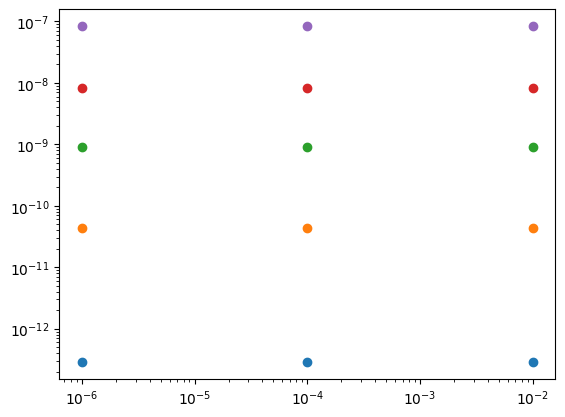

In [128]:
mask = original_system_id == 20
for temp in np.unique(target_temp[mask]):
    mask2 = (target_temp == temp) & mask
    plt.scatter(-delta_phi[mask2], pressure[mask2])
plt.xscale('log')
plt.yscale('log')

1e-12 -0.01 []
1e-12 -0.0001 []
1e-12 -1e-06 []
1e-11 -0.01 [0.01445458 0.01339373 0.01445458 0.01339373]
1e-11 -0.0001 [0.01445458 0.01339373 0.01445458 0.01339373]
1e-11 -1e-06 [0.01445458 0.01339373 0.01445458 0.01339373]
1e-10 -0.01 [0.02278051 0.0264827  0.04871746 0.00755066 0.02278051 0.02291298
 0.04222727 0.0264827  0.01800092 0.03823767 0.02466394 0.02267036
 0.04222727 0.01824963 0.01800092 0.03823767 0.01824963 0.0260295
 0.02291298 0.02466394 0.04871746 0.0260295  0.00755066 0.02267036]
1e-10 -0.0001 [0.02278051 0.0264827  0.04871746 0.00755066 0.02278051 0.02291298
 0.04222727 0.0264827  0.01800092 0.03823767 0.02466394 0.02267036
 0.04222727 0.01824963 0.01800092 0.03823767 0.01824963 0.0260295
 0.02291298 0.02466394 0.04871746 0.0260295  0.00755066 0.02267036]
1e-10 -1e-06 [0.02278051 0.0264827  0.04871746 0.00755066 0.02278051 0.02291298
 0.04222727 0.0264827  0.01800092 0.03823767 0.02466394 0.02267036
 0.04222727 0.01824963 0.01800092 0.03823767 0.01824963 0.0260295


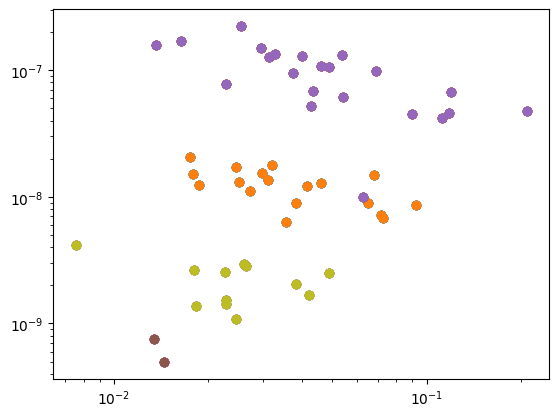

In [130]:
mask = original_system_id == 20
ids = np.arange(final.n_systems())
for temp in np.unique(target_temp[mask]):
    mask2 = (target_temp == temp) & mask
    for dphi in np.unique(delta_phi[mask2]):
        mask3 = (delta_phi == dphi) & mask2
        sid = ids[mask3][0]
        beg = final.system_offset[sid]
        end = final.system_offset[sid + 1]
        
        pair_mask = ((pair_ids[0, :, 0] >= beg) & (pair_ids[0, :, 0] < end))
        d = -mean_overlap[pair_mask]
        f = mean_force[pair_mask]
        plt.scatter(d[f > 0], f[f > 0])
        print(temp, dphi, d[f > 0])
plt.yscale('log')
plt.xscale('log')

IndexError: invalid index to scalar variable.

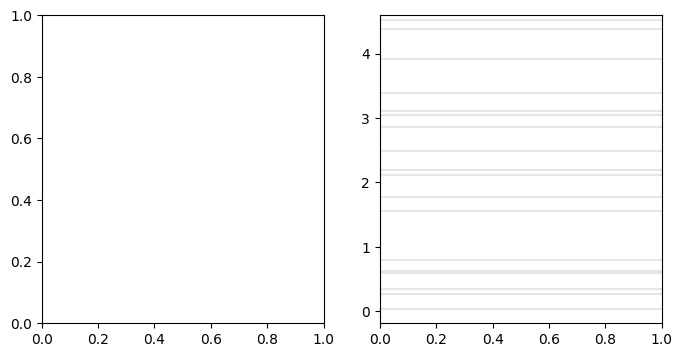

In [82]:
vel = final.trajectory.vel
disp = final.trajectory.pos - np.mean(final.trajectory.pos, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for sid in range(final.n_systems()):
    original_sid = final.original_system_id[sid]
    if original_sid != 0:
        break
    vel_i = vel[:, final.system_offset[sid]:final.system_offset[sid + 1], :].copy()
    vel_flat = np.concatenate([vel_i[:, :, i] for i in range(vel_i.shape[-1])], axis=1)
    V = vel_flat.T @ vel_flat

    disp_i = disp[:, final.system_offset[sid]:final.system_offset[sid + 1], :].copy()
    disp_flat = np.concatenate([disp_i[:, :, i] for i in range(disp_i.shape[-1])], axis=1)
    C = disp_flat.T @ disp_flat

    m = final.mass[final.system_offset[sid]:final.system_offset[sid + 1]].copy()
    M = np.diag(np.concatenate([m, m]))

    L, Y, S = get_S_modes_from_matrices(M, C, V)
    pvals, pvecs = np.linalg.eigh(V @ np.linalg.pinv(C))
    val = val_list[original_sid]
    delta_phi = final.delta_phi[sid]
    # plt.plot(val)
    # plt.plot(L)
    # plt.plot(pvals)
    # plt.scatter([delta_phi])
    for v in val[val > 1e-12]:
        ax[int(delta_phi < 0)].axhline(v, color='k', zorder=0, alpha=0.1)
    # ax[int(delta_phi < 0)].scatter([abs(delta_phi)] * len(val), val, color='k')
    ax[int(delta_phi < 0)].scatter([temp[sid]] * len(L), L, color='r')
    print(temp[sid])
    # ax[int(delta_phi < 0)].scatter([abs(delta_phi)] * len(pvals), pvals, color='b')
for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')


In [ ]:
plt.plot(*disp[:, 0].T)

In [ ]:
desired_frames = 100
steps_to_animate = downsample(final, desired_frames)

output_path = "anim.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,
    bitrate=3000,
    data=final,
    system_id=8,
    use_pbc=True,
    which='particle',
    cmap_name='grey',
    id_scale=1.1
)